# Comparison of RaPiD (`rapid-models`) and GPyTorch (`gpytorch-mogp`) implementations

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import math

import gpytorch
import numpy as np
import torch
from einops import rearrange
from matplotlib import pyplot as plt

from gpytorch_mogp.kernels import MultiOutputKernel
from gpytorch_mogp.likelihoods import FixedNoiseMultiOutputGaussianLikelihood
from gpytorch_mogp.utils import full_to_sparse_covariance

## Construct data for a 1D to 2D multi-output GP

In [3]:
# Config
n = 20
seed = 3407

# Noise config for correlated noise in training data
# Value `1` used for first half of points, value `2` used for second half of points
y1_noise_variance_1 = 0.003
y1_noise_variance_2 = 0.15
y2_noise_variance_1 = 0.15
y2_noise_variance_2 = 0.003
y1_y2_noise_correlation_1 = 0.05
y1_y2_noise_correlation_2 = 0.95

In [4]:
np.random.seed(seed)

In [5]:
# Ground truth function
def f(x):
    y1 = x ** np.sin(x * 10)
    y2 = (x + 0.3) ** 0.3 * np.cos(5 * x) + 1
    y = np.stack([y1, y2], axis=1)
    return y

In [6]:
# Construct noise arrays
n1 = math.ceil(n / 2)  # Length of first half
n2 = n - n1  # Length of second half

y1_noise_variance = np.concatenate([np.full(n1, y1_noise_variance_1), np.full(n2, y1_noise_variance_2)])
y2_noise_variance = np.concatenate([np.full(n1, y2_noise_variance_1), np.full(n2, y2_noise_variance_2)])
y1_y2_noise_correlation = np.concatenate(
    [np.full(n1, y1_y2_noise_correlation_1), np.full(n2, y1_y2_noise_correlation_2)]
)
y1_y2_noise_covariance = y1_y2_noise_correlation * (y1_noise_variance**0.5) * (y2_noise_variance**0.5)

# Stack to create sigma tensor (n, 2, 2)
sigma = rearrange(
    [y1_noise_variance, y1_y2_noise_covariance, y1_y2_noise_covariance, y2_noise_variance],
    "(a b) n -> n a b",
    n=n,
    a=2,
    b=2,
)

# Sample noise
train_noise = np.array([np.random.multivariate_normal([0, 0], sigma[i]) for i in range(n)])

In [7]:
# Generate training data
train_x = np.linspace(0, 1, n)
train_y = f(train_x) + train_noise

# Generate test data
test_x = np.linspace(0, 1, 100)

## Plotting function

In [8]:
def plot_gp(
    test_x: np.ndarray,
    mean: np.ndarray,
    variance: np.ndarray,
    covariance: np.ndarray | None = None,
    train_x: np.ndarray | None = None,
    train_y: np.ndarray | None = None,
    train_sigma: np.ndarray | None = None,
    title: str | None = None,
    color: str = "#0F204B",
    fontsize: int = 14,
):
    """Plot GP (1D to 2D)

    Args:
        test_x: An array of shape (n_points,).
        mean: An array of shape (n_points, n_y_dims).
        variance: An array of shape (n_points, n_y_dims).
        covariance: An array of shape (n_points, n_y_dims, n_y_dims). If provided, correlation will be plotted.
        train_x: An array of shape (n_train_points,).
        train_y: An array of shape (n_train_points, n_y_dims).
        train_sigma: An array of shape (n_train_points, n_y_dims, n_y_dims).
        title: The title to use for the plot.
        color: The color to use for the plot. Must be a valid matplotlib color (e.g. hex code, name).
        fontsize: The fontsize to use for the plot.
    """
    n_y_dims = mean.shape[1]
    fig, axs = plt.subplots(figsize=(16, 12), nrows=n_y_dims + (1 if covariance is not None else 0), sharex=True)

    for y_dim in range(2):
        ax = axs[y_dim]

        # GP mean and std
        y_mean = mean[:, y_dim]
        y_std = np.sqrt(variance[:, y_dim])

        # Plot GP mean
        ax.plot(test_x, y_mean, label="GP mean", color=color, linestyle="--")

        # Plot GP mean +- 2 std
        ax.fill_between(
            test_x, y_mean - 2 * y_std, y_mean + 2 * y_std, color=color, alpha=0.1, label="GP mean $\pm$ 2 std"
        )

        # Plot training data with noise
        if train_x is not None and train_y is not None:
            ax.errorbar(
                train_x,
                train_y[:, y_dim],
                yerr=2 * np.sqrt(train_sigma[:, y_dim, y_dim]),
                color=color,
                fmt="o",
                elinewidth=0.5,
                ms=4,
                label="Observations",
            )

        ax.set_ylabel(r"$y_1$", fontsize=fontsize)

        if y_dim == 0:  # Set legend only for first plot
            ax.legend(fontsize=fontsize - 2)

    if covariance is not None:
        ax = axs[-1]

        # Plot correlation from GP
        correlation = covariance[:, 0, 1] / np.sqrt(covariance[:, 0, 0] * covariance[:, 1, 1])
        ax.plot(test_x, correlation, color=color, linestyle="--", label="GP correlation")

        # Plot correlation in training data
        if train_sigma is not None:
            train_correlation = train_sigma[:, 0, 1] / np.sqrt(train_sigma[:, 0, 0] * train_sigma[:, 1, 1])
            ax.scatter(train_x, train_correlation, s=10, color="k", label="Observed correlation")

        ax.set_xlabel(r"$x$", fontsize=fontsize)
        ax.set_ylabel(r"Correlation coefficient", fontsize=fontsize)
        ax.legend(fontsize=fontsize - 2)
        ax.set_ylim((0, 1))

    if title is not None:
        fig.suptitle(title, fontsize=fontsize + 2)
    fig.tight_layout()
    plt.show()

## Comparison

### RaPiD

In [9]:
from rapid_models.gp.kernels import kernel_Matern52
from rapid_models.gp.model_nd import GPmodel_nd

# Define model
ker_1 = kernel_Matern52(variance=1, lengthscale=[0.5])
ker_2 = kernel_Matern52(variance=1, lengthscale=[0.5])

model_nd = GPmodel_nd([ker_1, ker_2], verbose=False)

# Pass training data to model
model_nd.X_training = train_x.reshape(-1, 1)
model_nd.Y_training = train_y
model_nd.Y_noise_variance = np.stack([y1_noise_variance, y2_noise_variance], axis=-1)
model_nd.Y_covariance = y1_y2_noise_covariance.reshape(-1, 1)

In [10]:
# Make predictions
mean, variance, covariance = model_nd.predict(test_x.reshape(-1, 1))

In [11]:
# Post-process into right format
# `rapid-models` returns lists of arrays, so we need to stack them...
# (n_y_dims, n_points) -> (n_points, n_y_dims)
mean = np.stack(mean, axis=-1)
# (n_y_dims, n_points) -> (n_points, n_y_dims)
variance = np.stack(variance, axis=-1)
# (n_y_dims, n_y_dims, n_points) -> (n_points, n_y_dims, n_y_dims)
covariance = np.array(covariance).transpose(2, 0, 1)

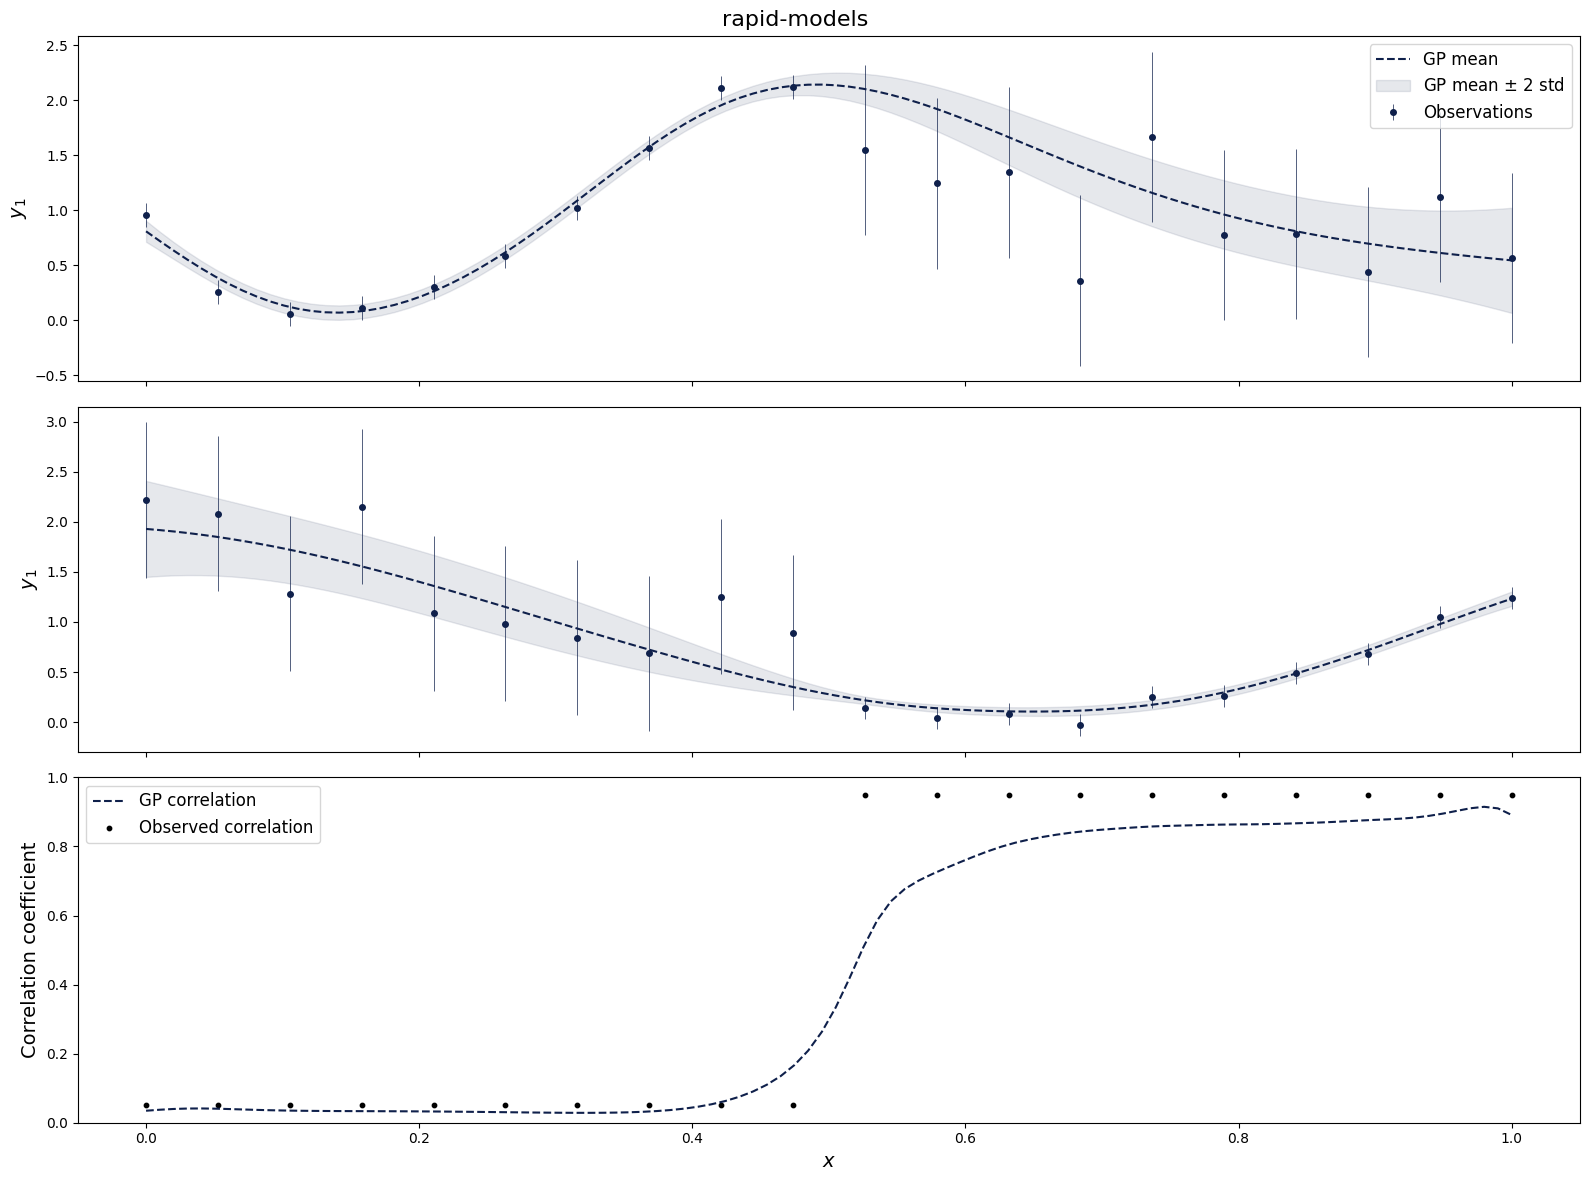

In [12]:
plot_gp(
    test_x=test_x,
    mean=mean,
    variance=variance,
    covariance=covariance,
    train_x=train_x,
    train_y=train_y,
    train_sigma=sigma,
    title="rapid-models",
)

In [13]:
rapid_models_mean = mean
rapid_models_variance = variance
rapid_models_covariance = covariance

### GPyTorch

In [14]:
# Define model
class MultiOutputGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(MultiOutputGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.MultitaskMean(gpytorch.means.ConstantMean(), num_tasks=2)
        kernel = gpytorch.kernels.MaternKernel()
        kernel.lengthscale = 0.5
        self.covar_module = MultiOutputKernel(
            kernel,
            num_outputs=2,
            make_copies=True,
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultitaskMultivariateNormal(mean_x, covar_x)


likelihood = FixedNoiseMultiOutputGaussianLikelihood(noise=torch.from_numpy(sigma), num_tasks=2)
model = MultiOutputGPModel(torch.from_numpy(train_x), torch.from_numpy(train_y), likelihood)

In [15]:
# Make predictions
model.eval()
predictions = model(torch.from_numpy(test_x))

In [16]:
# Post-process into right format
mean = predictions.mean.detach().numpy()
variance = predictions.variance.detach().numpy()
covariance = full_to_sparse_covariance(predictions.covariance_matrix.detach().numpy(), n_blocks=2, interleaved=True)

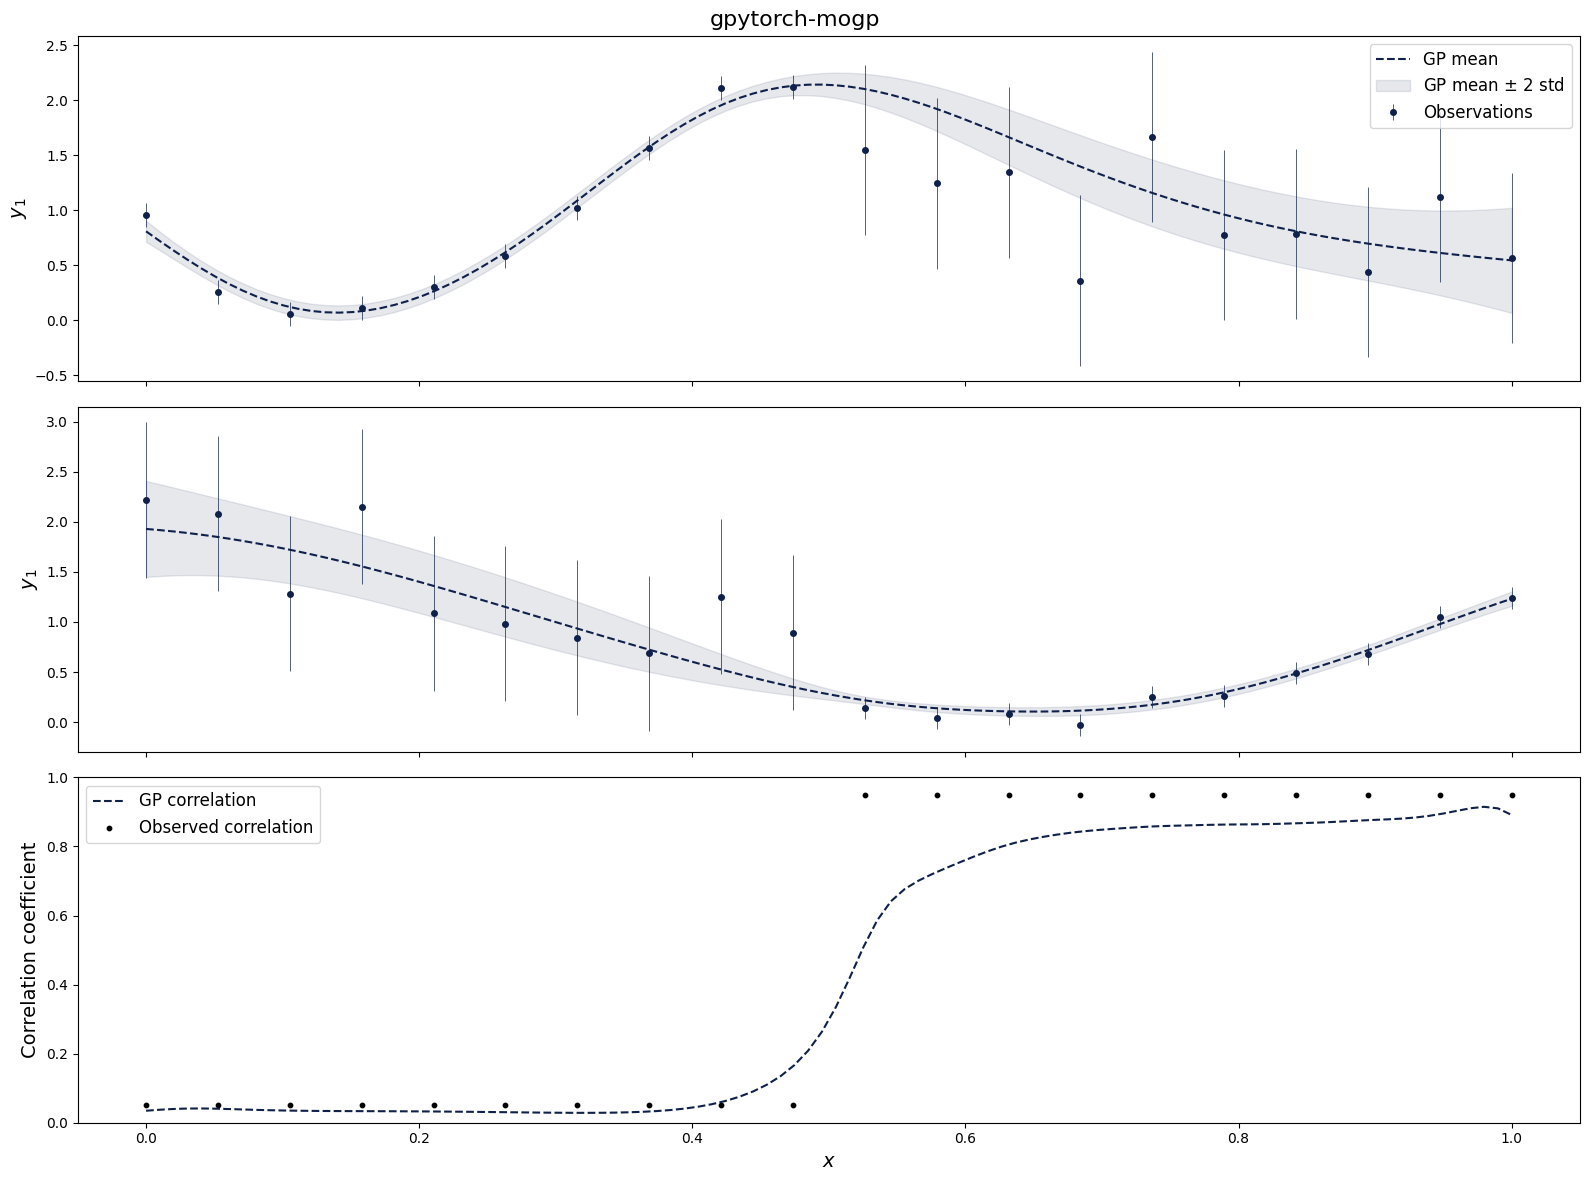

In [17]:
plot_gp(
    test_x=test_x,
    mean=mean,
    variance=variance,
    covariance=covariance,
    train_x=train_x,
    train_y=train_y,
    train_sigma=sigma,
    title="gpytorch-mogp",
)

In [18]:
gpytorch_mogp_mean = mean
gpytorch_mogp_variance = variance
gpytorch_mogp_covariance = covariance

In [19]:
# Compare predictions directly
assert np.allclose(rapid_models_mean, gpytorch_mogp_mean)
assert np.allclose(rapid_models_variance, gpytorch_mogp_variance)
assert np.allclose(rapid_models_covariance, gpytorch_mogp_covariance)